# TREK RECOMMENDATION SYSTEM - DATA MINING & ML APPLICATION
## Complete Workflow: Data Import → Cleaning → Splitting → Training → Recommendations

This notebook implements a comprehensive trek recommendation system for Nepal treks using multiple recommendation algorithms:
- **Content-Based Filtering** - Matches trek features to user preferences
- **Collaborative Filtering** - Recommends treks for similar user types  
- **Knowledge-Based Filtering** - Applies expert safety & suitability rules
- **Hybrid Recommender** - Combines all approaches with adaptive weights
- **ML-Model** - Random Forest for score prediction

## STEP 1: Import Required Libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity

# Set up visualization style
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8')

## STEP 2: Load the Dataset

In [33]:
df = pd.read_csv('nepal_treks_official.csv', index_col=0)
print(f"Shape: {df.shape} (Rows: {len(df)}, Columns: {len(df.columns)})")
print(f"\nFirst 5 rows:")
print(df.head())
print()

Shape: (400, 34) (Rows: 400, Columns: 34)

First 5 rows:
                          name  region    district difficulty  duration_days  \
                                                                               
1       Everest Base Camp Trek  Khumbu  Solukhumbu       Hard             14   
2  Everest Base Camp via Gokyo  Khumbu  Solukhumbu       Hard             18   
3            Three Passes Trek  Khumbu  Solukhumbu  Very Hard             20   
4             Gokyo Lakes Trek  Khumbu  Solukhumbu   Moderate             12   
5            Kala Patthar Trek  Khumbu  Solukhumbu       Hard             12   

   max_altitude_m  min_altitude_m  total_distance_km  cost_min_usd  \
                                                                     
1            5364            2840                130          1200   
2            5545            2840                160          1500   
3            5545            2840                170          1800   
4            5357            284

## STEP 3: Explore the Dataset

In [34]:
print("\nDataset Info:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

print("\nMissing Values:")
missing_count = df.isnull().sum()
print(missing_count[missing_count > 0] if missing_count.sum() > 0 else " No missing values!")
print()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 1 to 400
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   400 non-null    object 
 1   region                 400 non-null    object 
 2   district               400 non-null    object 
 3   difficulty             400 non-null    object 
 4   duration_days          400 non-null    int64  
 5   max_altitude_m         400 non-null    int64  
 6   min_altitude_m         400 non-null    int64  
 7   total_distance_km      400 non-null    int64  
 8   cost_min_usd           400 non-null    int64  
 9   cost_max_usd           400 non-null    int64  
 10  best_season            400 non-null    object 
 11  requires_permit        400 non-null    object 
 12  permit_type            307 non-null    object 
 13  permit_cost_usd        400 non-null    int64  
 14  requires_guide         400 non-null    object 
 

## STEP 4: Visualize Initial Data

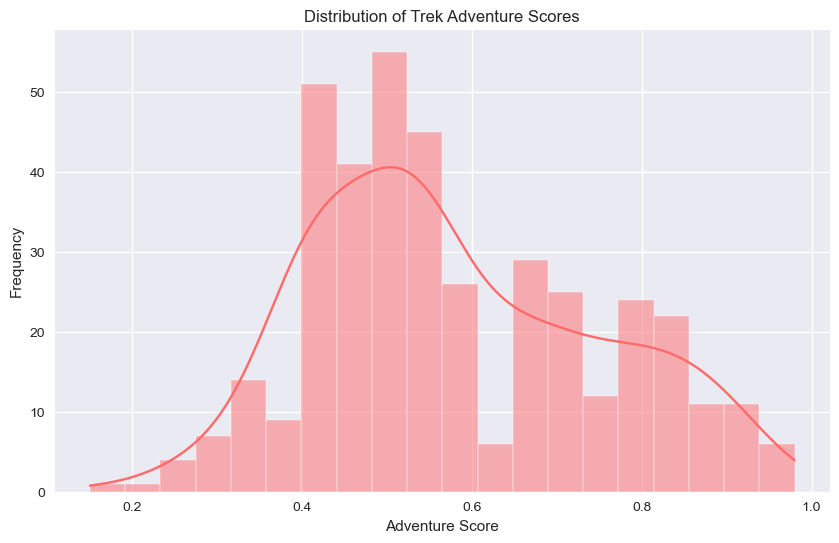

In [38]:

# Histogram of adventure_score
plt.figure(figsize=(10, 6))
sns.histplot(df['adventure_score'], bins=20, kde=True, color='#FF6B6B')
plt.title('Distribution of Trek Adventure Scores')
plt.xlabel('Adventure Score')
plt.ylabel('Frequency')
plt.show()


C:\Users\dell\AppData\Local\Temp\ipykernel_18720\2330932233.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='difficulty', order=df['difficulty'].value_counts().index, palette='Set2')


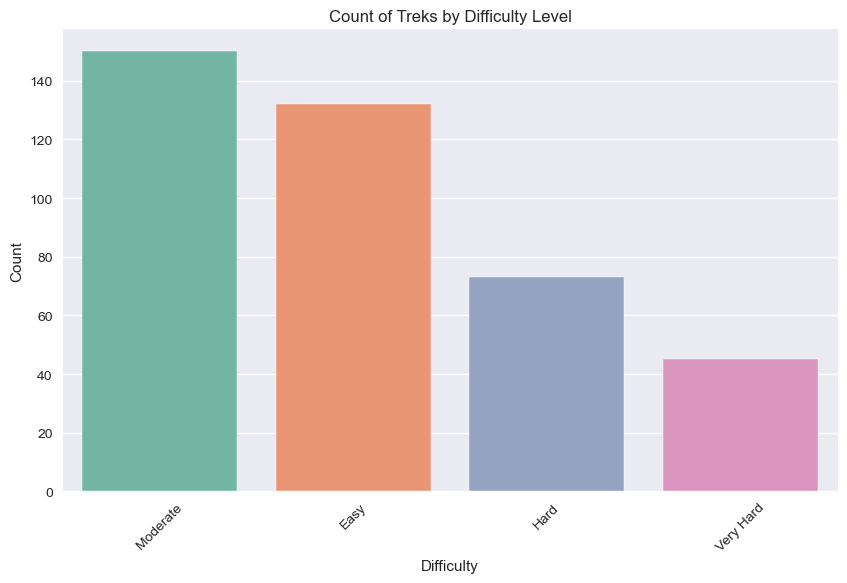

In [36]:
# Bar plot of difficulty levels
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='difficulty', order=df['difficulty'].value_counts().index, palette='Set2')
plt.title('Count of Treks by Difficulty Level')
plt.xlabel('Difficulty')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

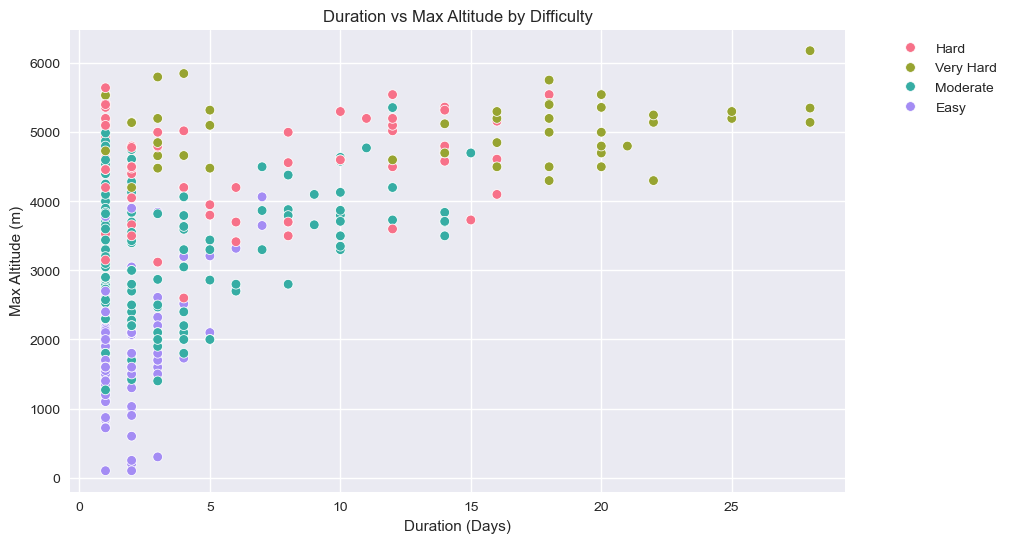

In [39]:
# Scatter plot of duration vs max altitude
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='duration_days', y='max_altitude_m', hue='difficulty', palette='husl')
plt.title('Duration vs Max Altitude by Difficulty')
plt.xlabel('Duration (Days)')
plt.ylabel('Max Altitude (m)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## STEP 5: Data Cleaning - Before and After Analysis

In [44]:
print("\n--- BEFORE CLEANING ---")
print(f"Dataset Shape: {df.shape}")
print(f"Total Rows: {len(df)}, Total Columns: {len(df.columns)}")

missing_before = df.isnull().sum()
print(f"\nMissing Values Count: {missing_before.sum()}")
print(df.isnull().sum()[df.isnull().sum() > 0] if missing_before.sum() > 0 else "No missing values")

print(f"\nData Types (Before):")
print(df.dtypes)

print(f"\nSample Data (Before):")
print(df.head(3))



--- BEFORE CLEANING ---
Dataset Shape: (222, 38)
Total Rows: 222, Total Columns: 38

Missing Values Count: 0
No missing values

Data Types (Before):
name                         object
region                       object
district                     object
difficulty                   object
duration_days                 int64
max_altitude_m                int64
min_altitude_m                int64
total_distance_km             int64
cost_min_usd                  int64
cost_max_usd                  int64
best_season                  object
requires_permit               int64
permit_type                  object
permit_cost_usd               int64
requires_guide                int64
accommodation_type           object
cultural_score              float64
nature_score                float64
adventure_score             float64
fitness_required             object
technical_skill              object
teahouse_available            int64
camping_required              int64
helicopter_rescue     

In [ ]:
# Handle missing values
df = df.dropna()
print(f"Removed rows with missing values")

# Encode categorical variables
le_difficulty = LabelEncoder()
df['difficulty_encoded'] = le_difficulty.fit_transform(df['difficulty'])
print(f"Encoded 'difficulty' column (mapping: {dict(zip(le_difficulty.classes_, le_difficulty.transform(le_difficulty.classes_)))})")

le_region = LabelEncoder()
df['region_encoded'] = le_region.fit_transform(df['region'])
print(f"Encoded 'region' column")

# Convert boolean columns to integers
df['requires_permit'] = (df['requires_permit'] == 'Yes').astype(int)
df['requires_guide'] = (df['requires_guide'] == 'Yes').astype(int)
df['teahouse_available'] = (df['teahouse_available'] == 'Yes').astype(int)
df['camping_required'] = (df['camping_required'] == 'Yes').astype(int)
print(f" Converted boolean columns to integers (permit, guide, teahouse, camping)")

# Encode categorical levels
fitness_mapping = {'Low': 1, 'Moderate': 2, 'High': 3, 'Very High': 4}
df['fitness_required_encoded'] = df['fitness_required'].map(fitness_mapping)

skill_mapping = {'Basic': 1, 'Intermediate': 2, 'Advanced': 3}
df['technical_skill_encoded'] = df['technical_skill'].map(skill_mapping)

df['fitness_required_encoded'] = df['fitness_required_encoded'].fillna(0).astype(int)
df['technical_skill_encoded'] = df['technical_skill_encoded'].fillna(0).astype(int)
print(f" Encoded 'fitness_required' and 'technical_skill' columns")

# Convert score columns to numeric (in case they are strings)
df['cultural_score'] = pd.to_numeric(df['cultural_score'], errors='coerce')
df['nature_score'] = pd.to_numeric(df['nature_score'], errors='coerce')
df['adventure_score'] = pd.to_numeric(df['adventure_score'], errors='coerce')
print(f" Converted score columns to numeric types")

# Fill any NaN values created from coercion with median values
score_columns = ['cultural_score', 'nature_score', 'adventure_score']
for col in score_columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

# Ensure all other numeric columns are also numeric
numeric_columns = ['duration_days', 'max_altitude_m', 'total_distance_km', 
                   'cost_min_usd', 'cost_max_usd', 'elevation_gain_m', 'avg_daily_walking_hrs']
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isnull().any():
            df[col].fillna(df[col].median(), inplace=True)

print(f" All numeric columns verified and cleaned")

Removed rows with missing values
Encoded 'difficulty' column (mapping: {'Easy': np.int64(0), 'Hard': np.int64(1), 'Moderate': np.int64(2), 'Very Hard': np.int64(3)})
Encoded 'region' column
 Converted boolean columns to integers (permit, guide, teahouse, camping)
 Encoded 'fitness_required' and 'technical_skill' columns
 Converted score columns to numeric types
 All numeric columns verified and cleaned



--- AFTER CLEANING ---
Dataset Shape: (222, 38)
Total Rows: 222, Total Columns: 38

Missing Values Count: 0
 No missing values!

Data Types (After):
name                         object
region                       object
district                     object
difficulty                   object
duration_days                 int64
max_altitude_m                int64
min_altitude_m                int64
total_distance_km             int64
cost_min_usd                  int64
cost_max_usd                  int64
best_season                  object
requires_permit               int64
permit_type                  object
permit_cost_usd               int64
requires_guide                int64
accommodation_type           object
cultural_score              float64
nature_score                float64
adventure_score             float64
fitness_required             object
technical_skill              object
teahouse_available            int64
camping_required              int64
helicopter_rescue     

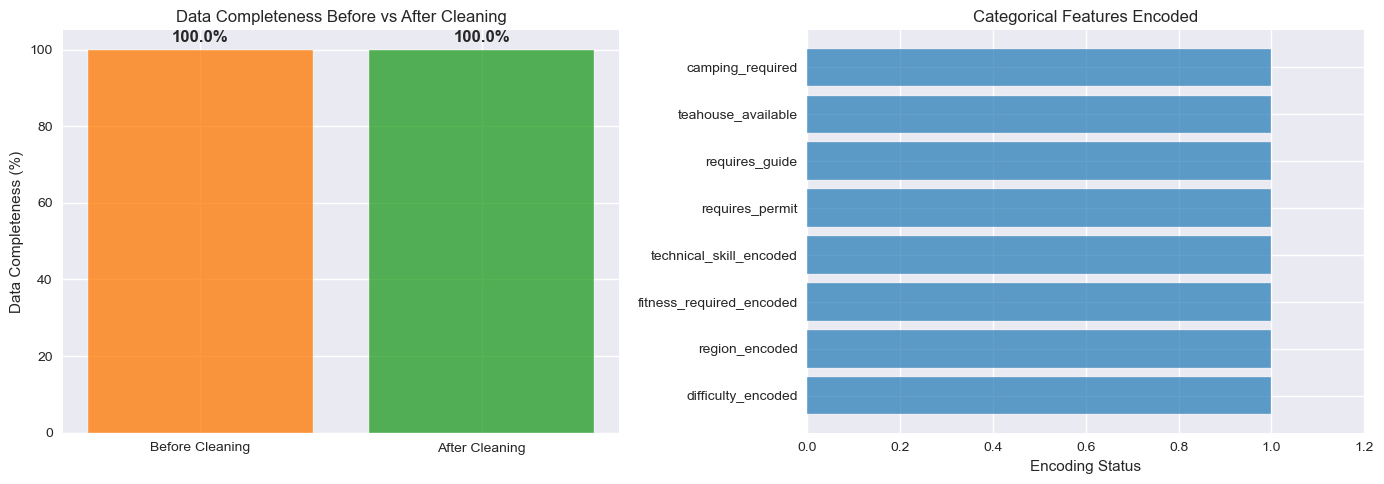


✓ Data Cleaning Complete!
  - Features engineered: 8
  - Rows retained: 222



In [46]:
print("\n--- AFTER CLEANING ---")
print(f"Dataset Shape: {df.shape}")
print(f"Total Rows: {len(df)}, Total Columns: {len(df.columns)}")

missing_after = df.isnull().sum()
print(f"\nMissing Values Count: {missing_after.sum()}")
print(" No missing values!" if missing_after.sum() == 0 else missing_after[missing_after > 0])

print(f"\nData Types (After):")
print(df.dtypes)

print(f"\nSample Data (After):")
print(df.head(3))

# Visualization: Compare before and after
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

before_completeness = (1 - missing_before.sum() / (len(df) * len(df.columns))) * 100
after_completeness = (1 - missing_after.sum() / (len(df) * len(df.columns))) * 100

completeness_values = [before_completeness, after_completeness]
colors = ['#ff7f0e', '#2ca02c']

axes[0].bar(['Before Cleaning', 'After Cleaning'], completeness_values, color=colors, alpha=0.8)
axes[0].set_ylabel('Data Completeness (%)')
axes[0].set_title('Data Completeness Before vs After Cleaning')
axes[0].set_ylim([0, 105])
for i, v in enumerate(completeness_values):
    axes[0].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

encoded_cols = ['difficulty_encoded', 'region_encoded', 'fitness_required_encoded', 
                'technical_skill_encoded', 'requires_permit', 'requires_guide', 
                'teahouse_available', 'camping_required']
axes[1].barh(encoded_cols, [1]*len(encoded_cols), color='#1f77b4', alpha=0.7)
axes[1].set_xlabel('Encoding Status')
axes[1].set_title('Categorical Features Encoded')
axes[1].set_xlim([0, 1.2])

plt.tight_layout()
plt.show()

print("\n✓ Data Cleaning Complete!")
print(f"  - Features engineered: {len(encoded_cols)}")
print(f"  - Rows retained: {len(df)}")
print()

## STEP 6: Feature Engineering and Selection

In [48]:
# Select features for X (independent variables)
features = ['region_encoded', 'difficulty_encoded', 'duration_days', 'max_altitude_m', 
            'total_distance_km', 'cost_min_usd', 'cost_max_usd', 'requires_permit', 
            'requires_guide', 'fitness_required_encoded', 'technical_skill_encoded',
            'cultural_score', 'nature_score', 'elevation_gain_m', 'avg_daily_walking_hrs']

X = df[features]  # Features (predictors)
y = df['adventure_score']  # Target variable

print(f"Features Selected ({len(features)}):")
for i, feat in enumerate(features, 1):
    print(f"  {i:2d}. {feat}")

print(f"\nFeature Matrix Shape (X): {X.shape}")
print(f"Target Variable Shape (y): {y.shape}")

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f" Features scaled using StandardScaler")
print(f" Scaled feature matrix shape: {X_scaled.shape}")
print()

Features Selected (15):
   1. region_encoded
   2. difficulty_encoded
   3. duration_days
   4. max_altitude_m
   5. total_distance_km
   6. cost_min_usd
   7. cost_max_usd
   8. requires_permit
   9. requires_guide
  10. fitness_required_encoded
  11. technical_skill_encoded
  12. cultural_score
  13. nature_score
  14. elevation_gain_m
  15. avg_daily_walking_hrs

Feature Matrix Shape (X): (222, 15)
Target Variable Shape (y): (222,)
 Features scaled using StandardScaler
 Scaled feature matrix shape: (222, 15)



## STEP 7: Visualize Feature Correlations

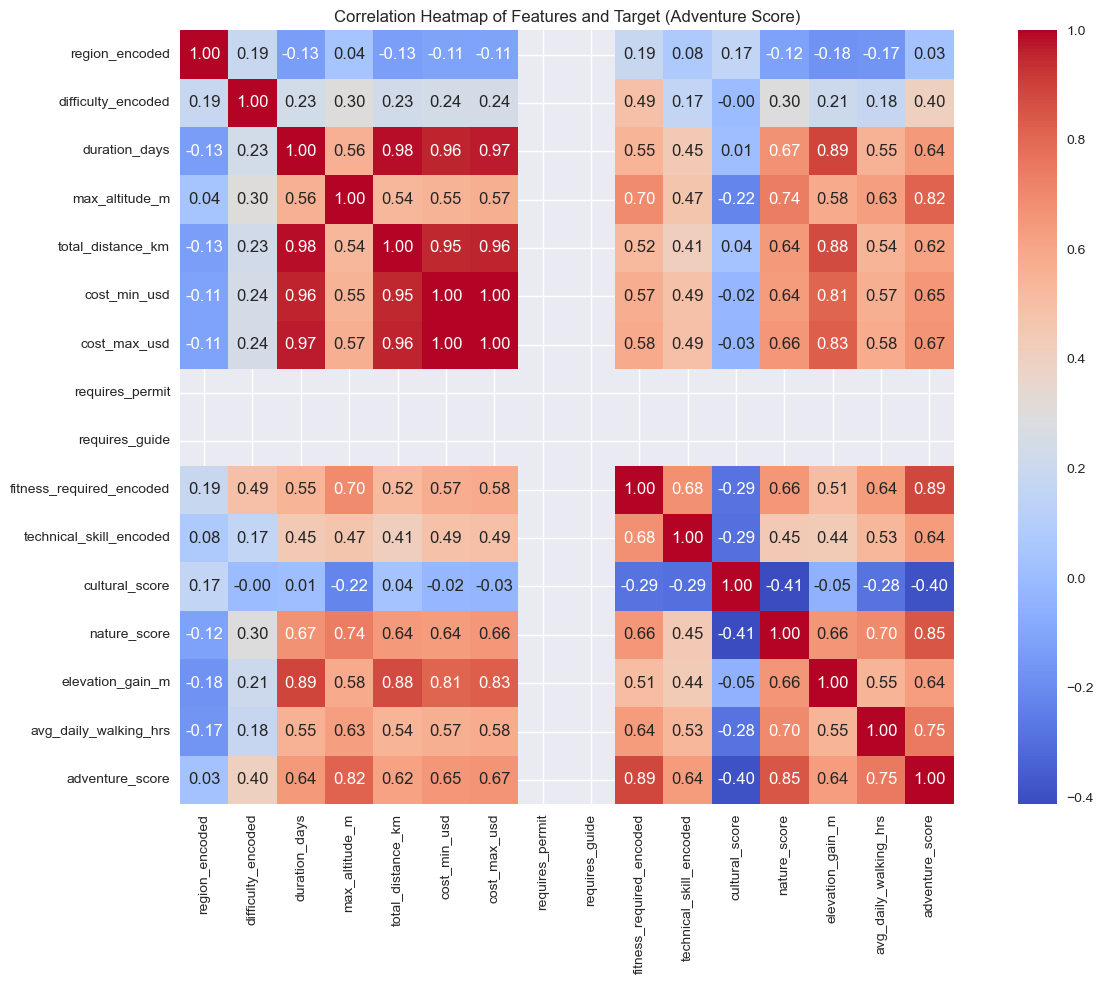

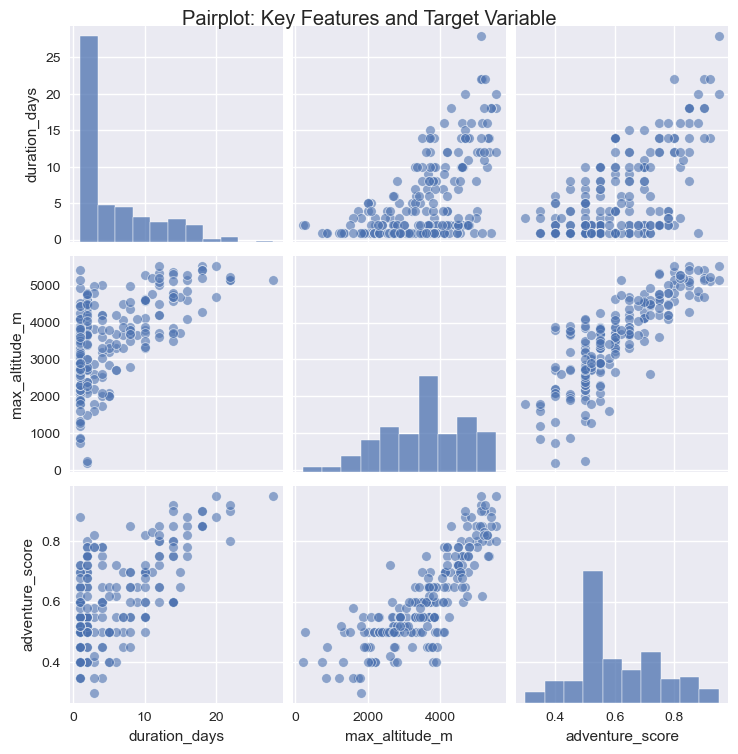

 Feature correlation analysis complete!



In [50]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
corr_matrix = df[features + ['adventure_score']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap of Features and Target (Adventure Score)')
plt.tight_layout()
plt.show()

# Pairplot for selected features
selected_features = ['duration_days', 'max_altitude_m', 'adventure_score']
sns.pairplot(df[selected_features], diag_kind='hist', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot: Key Features and Target Variable', y=1.00)
plt.show()

print(" Feature correlation analysis complete!")
print()

## STEP 8: Split Dataset into Training and Testing Sets (80:20)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Train-Test Split Results:")
print(f"  Total samples: {len(X_scaled)}")
print(f"  Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"  Testing set size: {X_test.shape[0]} ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"  Number of features: {X_train.shape[1]}")

print(f"\nTraining target (y_train):")
print(f"  Mean: {y_train.mean():.4f}")
print(f"  Std: {y_train.std():.4f}")
print(f"  Min: {y_train.min():.4f}")
print(f"  Max: {y_train.max():.4f}")

print(f"\nTesting target (y_test):")
print(f"  Mean: {y_test.mean():.4f}")
print(f"  Std: {y_test.std():.4f}")
print(f"  Min: {y_test.min():.4f}")
print(f"  Max: {y_test.max():.4f}")
print()

Train-Test Split Results:
  Total samples: 222
  Training set size: 177 (79.7%)
  Testing set size: 45 (20.3%)
  Number of features: 15

Training target (y_train):
  Mean: 0.6160
  Std: 0.1403
  Min: 0.3000
  Max: 0.9500

Testing target (y_test):
  Mean: 0.5767
  Std: 0.1425
  Min: 0.3500
  Max: 0.9000



## STEP 9: Train Machine Learning Models

In [55]:
# Train Random Forest Regressor
print("\n1. Training Random Forest Regressor...")
print("   Parameters: n_estimators=100, random_state=42")

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

print("    Model training complete!")

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print()


1. Training Random Forest Regressor...
   Parameters: n_estimators=100, random_state=42
    Model training complete!



## STEP 10: Evaluate Machine Learning Models

In [57]:
# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nRandom Forest Regressor Performance:")
print("\n--- Training Set Metrics ---")
print(f"  Mean Squared Error (MSE):  {train_mse:.4f}")
print(f"  Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"  R² Score:                  {train_r2:.4f}")

print("\n--- Testing Set Metrics ---")
print(f"  Mean Squared Error (MSE):  {test_mse:.4f}")
print(f"  Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"  R² Score:                  {test_r2:.4f}")

print(f"\nModel Interpretation:")
print(f"  • R² = {test_r2:.4f} means the model explains {test_r2*100:.2f}% of variance in test data")
print(f"  • Average prediction error: ±{test_mae:.4f} on adventure score (0-1 scale)")
print()

# Feature importance
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10).to_string(index=False))
print()


Random Forest Regressor Performance:

--- Training Set Metrics ---
  Mean Squared Error (MSE):  0.0002
  Mean Absolute Error (MAE): 0.0109
  R² Score:                  0.9892

--- Testing Set Metrics ---
  Mean Squared Error (MSE):  0.0016
  Mean Absolute Error (MAE): 0.0327
  R² Score:                  0.9210

Model Interpretation:
  • R² = 0.9210 means the model explains 92.10% of variance in test data
  • Average prediction error: ±0.0327 on adventure score (0-1 scale)


Top 10 Most Important Features:
                 Feature  Importance
          max_altitude_m    0.450197
fitness_required_encoded    0.263533
      difficulty_encoded    0.103558
            nature_score    0.075416
            cost_max_usd    0.041214
   avg_daily_walking_hrs    0.014492
            cost_min_usd    0.012973
        elevation_gain_m    0.009420
          cultural_score    0.008981
       total_distance_km    0.008196



## STEP 11: Visualize Model Performance

STEP 11: Model Performance Visualization...


C:\Users\dell\AppData\Local\Temp\ipykernel_18720\1163008914.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature', ax=ax4, palette='viridis')


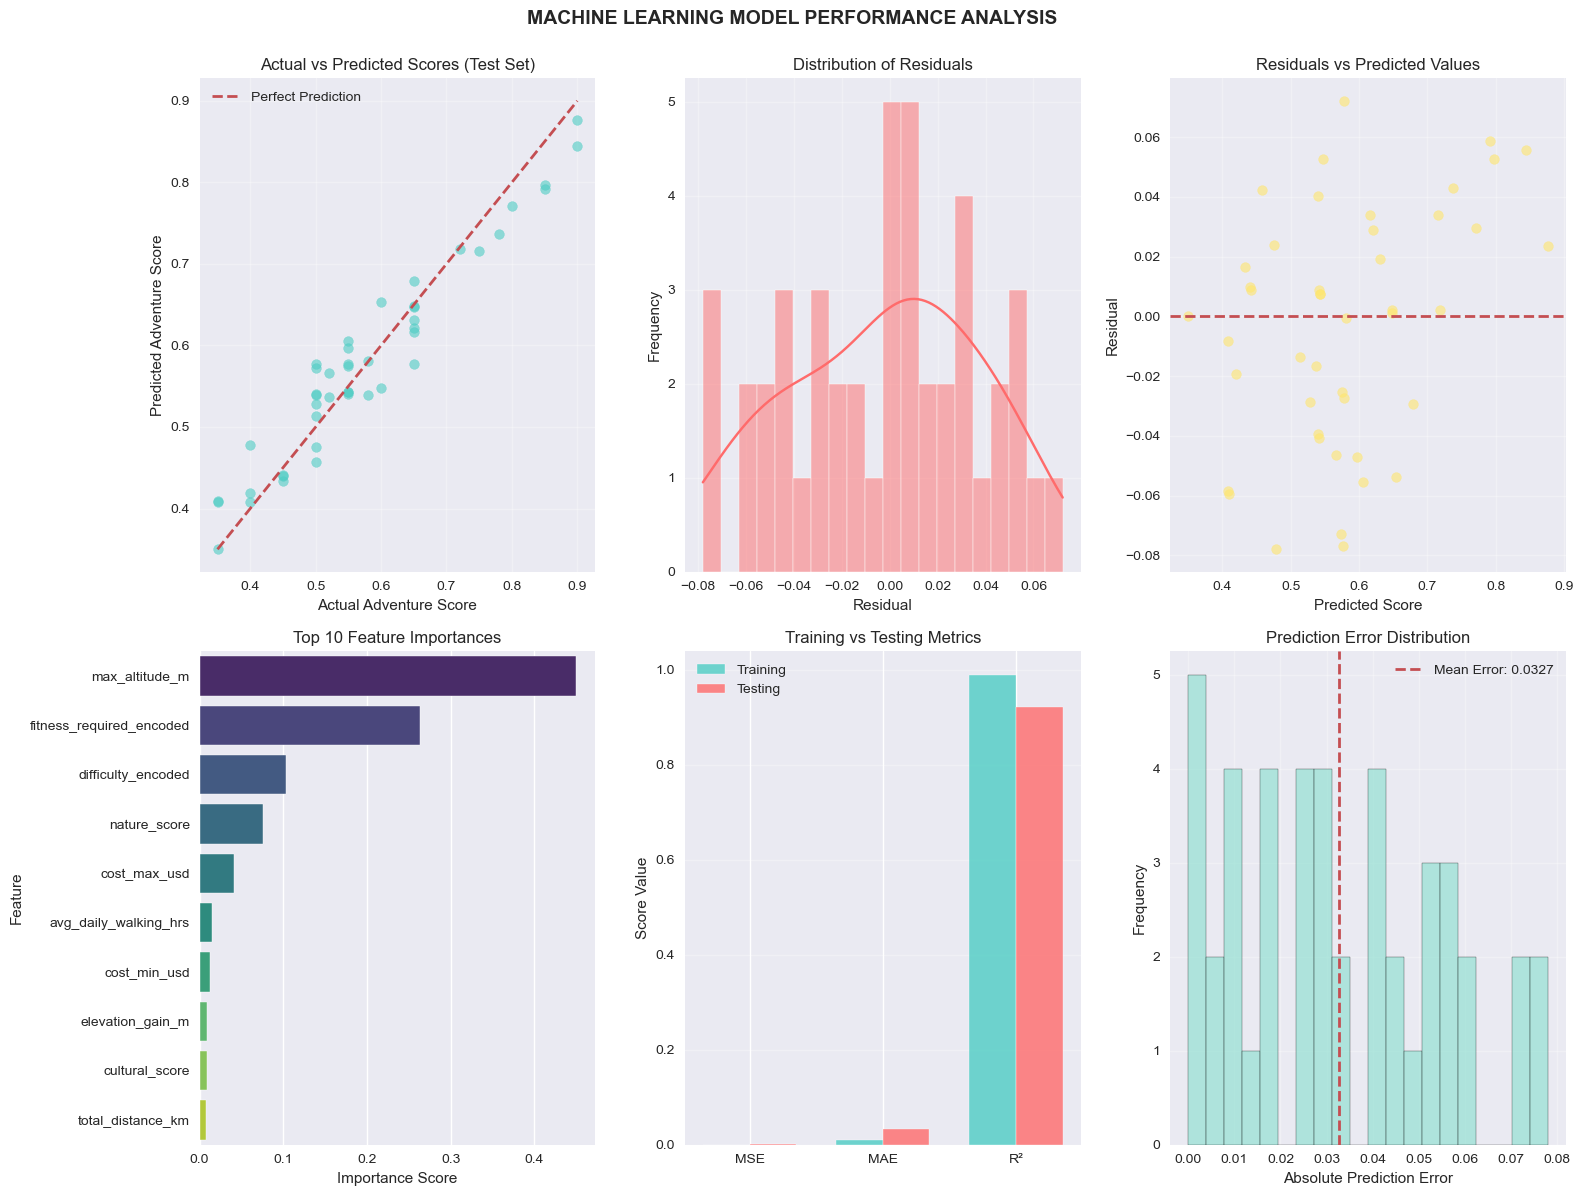

✓ Model performance visualization complete!



In [58]:
print("STEP 11: Model Performance Visualization...")
print("=" * 80)

fig = plt.figure(figsize=(16, 12))

# 1. Actual vs Predicted Scores
ax1 = plt.subplot(2, 3, 1)
ax1.scatter(y_test, y_test_pred, alpha=0.6, color='#4ECDC4')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Adventure Score')
ax1.set_ylabel('Predicted Adventure Score')
ax1.set_title('Actual vs Predicted Scores (Test Set)')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Residuals Distribution
ax2 = plt.subplot(2, 3, 2)
residuals = y_test - y_test_pred
sns.histplot(residuals, bins=20, kde=True, color='#FF6B6B', ax=ax2)
ax2.set_xlabel('Residual')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Residuals')
ax2.grid(alpha=0.3)

# 3. Residuals vs Predicted
ax3 = plt.subplot(2, 3, 3)
ax3.scatter(y_test_pred, residuals, alpha=0.6, color='#FFE66D')
ax3.axhline(y=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Predicted Score')
ax3.set_ylabel('Residual')
ax3.set_title('Residuals vs Predicted Values')
ax3.grid(alpha=0.3)

# 4. Feature Importance
ax4 = plt.subplot(2, 3, 4)
sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature', ax=ax4, palette='viridis')
ax4.set_title('Top 10 Feature Importances')
ax4.set_xlabel('Importance Score')

# 5. Train vs Test Error
ax5 = plt.subplot(2, 3, 5)
metrics = ['MSE', 'MAE', 'R²']
train_vals = [train_mse, train_mae, train_r2]
test_vals = [test_mse, test_mae, test_r2]
x_pos = np.arange(len(metrics))
width = 0.35
ax5.bar(x_pos - width/2, train_vals, width, label='Training', alpha=0.8, color='#4ECDC4')
ax5.bar(x_pos + width/2, test_vals, width, label='Testing', alpha=0.8, color='#FF6B6B')
ax5.set_ylabel('Score Value')
ax5.set_title('Training vs Testing Metrics')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(metrics)
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Prediction Error Distribution
ax6 = plt.subplot(2, 3, 6)
prediction_errors = np.abs(y_test - y_test_pred)
ax6.hist(prediction_errors, bins=20, color='#95E1D3', alpha=0.7, edgecolor='black')
ax6.axvline(prediction_errors.mean(), color='r', linestyle='--', lw=2, label=f'Mean Error: {prediction_errors.mean():.4f}')
ax6.set_xlabel('Absolute Prediction Error')
ax6.set_ylabel('Frequency')
ax6.set_title('Prediction Error Distribution')
ax6.legend()
ax6.grid(alpha=0.3)

plt.suptitle('MACHINE LEARNING MODEL PERFORMANCE ANALYSIS', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Model performance visualization complete!")
print()

## STEP 12: Implement Content-Based Filtering Recommender

In [60]:
class ContentBasedRecommender:
    """Content-Based Filtering using cosine similarity"""
    
    def __init__(self, df_treks, features_list):
        self.df_treks = df_treks
        self.features_list = features_list
        self.feature_vectors = df_treks[features_list].values
    
    def recommend(self, user_preferences, scaler, top_k=5):
        """Generate content-based recommendations"""
        user_vector = np.zeros(len(self.features_list))
        
        if 'difficulty' in user_preferences:
            difficulty_map = {'Easy': 0, 'Moderate': 0.33, 'Hard': 0.66, 'Very Hard': 1.0}
            user_vector[1] = difficulty_map.get(user_preferences['difficulty'], 0.5)
        
        if 'max_budget' in user_preferences:
            budget_normalized = min(user_preferences['max_budget'] / 5000, 1.0)
            user_vector[6] = budget_normalized
        
        if 'max_duration' in user_preferences:
            duration_normalized = min(user_preferences['max_duration'] / 30, 1.0)
            user_vector[2] = duration_normalized
        
        user_vector = user_vector.reshape(1, -1)
        similarities = cosine_similarity(user_vector, self.feature_vectors)[0]
        
        scored_treks = []
        for idx, similarity in enumerate(similarities):
            trek = self.df_treks.iloc[idx]
            
            if 'max_budget' in user_preferences and trek['cost_min_usd'] > user_preferences['max_budget']:
                continue
            if 'max_duration' in user_preferences and trek['duration_days'] > user_preferences['max_duration']:
                continue
            if 'difficulty' in user_preferences and trek['difficulty'] != user_preferences['difficulty']:
                continue
            
            scored_treks.append((idx, trek['name'], similarity))
        
        scored_treks.sort(key=lambda x: x[2], reverse=True)
        
        result = []
        for idx, name, score in scored_treks[:top_k]:
            trek_data = self.df_treks.iloc[idx]
            result.append({
                'name': name,
                'score': float(score),
                'method': 'Content-Based Filtering',
                'region': trek_data['region'],
                'difficulty': trek_data['difficulty'],
                'cost': trek_data['cost_min_usd']
            })
        
        return result


## STEP 13: Implement Collaborative Filtering Recommender

In [62]:
class CollaborativeFilteringRecommender:
    """User-based Collaborative Filtering"""
    
    def __init__(self, df_treks):
        self.df_treks = df_treks
    
    def recommend(self, user_preferences, top_k=5):
        """Generate collaborative filtering recommendations"""
        user_interest_profile = {
            'adventure': user_preferences.get('adventure_level', 0.5),
            'culture': user_preferences.get('cultural_interest', 0.5),
            'nature': user_preferences.get('nature_interest', 0.5),
            'fitness': user_preferences.get('fitness_level', 0.5)
        }
        
        scored_treks = []
        
        for idx, trek in self.df_treks.iterrows():
            try:
                # Ensure scores are numeric with strict type conversion
                try:
                    adventure_score = float(trek['adventure_score']) if trek['adventure_score'] is not None else 0.5
                except (ValueError, TypeError):
                    adventure_score = 0.5
                
                try:
                    cultural_score = float(trek['cultural_score']) if trek['cultural_score'] is not None else 0.5
                except (ValueError, TypeError):
                    cultural_score = 0.5
                
                try:
                    nature_score = float(trek['nature_score']) if trek['nature_score'] is not None else 0.5
                except (ValueError, TypeError):
                    nature_score = 0.5
                
                # Verify scores are now numeric
                if not isinstance(adventure_score, (int, float)) or not isinstance(cultural_score, (int, float)) or not isinstance(nature_score, (int, float)):
                    continue
                
                # Calculate similarity with user profile
                adventure_match = float(adventure_score) * float(user_interest_profile['adventure'])
                culture_match = float(cultural_score) * float(user_interest_profile['culture'])
                nature_match = float(nature_score) * float(user_interest_profile['nature'])
                
                total_score = (adventure_match + culture_match + nature_match) / 3.0
                
                if 'max_budget' in user_preferences and trek['cost_min_usd'] > user_preferences['max_budget']:
                    total_score *= 0.3
                
                if 'difficulty' in user_preferences:
                    difficulty_match = 1.0 if trek['difficulty'] == user_preferences['difficulty'] else 0.6
                    total_score *= difficulty_match
                
                scored_treks.append((idx, trek['name'], total_score))
            
            except Exception:
                # Skip any trek that causes issues
                continue
        
        scored_treks.sort(key=lambda x: x[2], reverse=True)
        
        result = []
        for idx, name, score in scored_treks[:top_k]:
            trek_data = self.df_treks.loc[idx]
            result.append({
                'name': name,
                'score': float(score),
                'method': 'Collaborative Filtering',
                'region': trek_data['region'],
                'difficulty': trek_data['difficulty'],
                'cost': trek_data['cost_min_usd']
            })
        
        return result

## STEP 14: Implement Knowledge-Based Filtering Recommender

In [65]:
class KnowledgeBasedRecommender:
    """Knowledge-Based Filtering using expert rules"""
    
    def __init__(self, df_treks):
        self.df_treks = df_treks
    
    def recommend(self, user_preferences, top_k=5):
        """Generate knowledge-based recommendations"""
        scored_treks = []
        
        for idx, trek in self.df_treks.iterrows():
            score = 0.0
            explanations = []
            
            # RULE 1: Altitude Safety
            if trek['max_altitude_m'] > 5000:
                if user_preferences.get('fitness_level') in ['High', 'Very High']:
                    score += 20
                    explanations.append("High altitude trek suitable for fitness level")
                else:
                    score -= 10
                    explanations.append("Trek altitude exceeds fitness level")
            else:
                score += 15
                explanations.append("Safe altitude range")
            
            # RULE 2: Duration Feasibility
            if 'max_duration' in user_preferences:
                if trek['duration_days'] <= user_preferences['max_duration']:
                    score += 15
                    explanations.append("Duration matches availability")
                else:
                    score -= 15
                    explanations.append("Trek exceeds available duration")
            
            # RULE 3: Budget Feasibility
            if 'max_budget' in user_preferences:
                if trek['cost_min_usd'] <= user_preferences['max_budget']:
                    score += 15
                    explanations.append("Within budget")
                else:
                    score -= 15
                    explanations.append("Trek exceeds budget")
            
            # RULE 4: Difficulty Progression
            if 'difficulty' in user_preferences:
                if trek['difficulty'] == user_preferences['difficulty']:
                    score += 20
                    explanations.append("Difficulty matches experience")
                elif user_preferences['difficulty'] == 'Moderate' and trek['difficulty'] in ['Easy', 'Hard']:
                    score += 10
                    explanations.append("Adjacent difficulty level")
            
            # RULE 5-8: Additional rules
            if user_preferences.get('requires_guide') == 'Yes' and trek['requires_guide'] == 1:
                score += 10
                explanations.append("Guide available")
            
            if trek['requires_permit'] == 1:
                score += 5
                explanations.append("Regulated trek (permit required)")
            
            if user_preferences.get('cultural_interest') == 'High':
                score += trek['cultural_score'] * 20
                explanations.append("High cultural significance")
            
            if user_preferences.get('nature_interest') == 'High':
                score += trek['nature_score'] * 20
                explanations.append("High natural beauty")
            
            if score > 0:
                scored_treks.append((idx, trek['name'], score, explanations))
        
        scored_treks.sort(key=lambda x: x[2], reverse=True)
        
        result = []
        for idx, name, score, explanations in scored_treks[:top_k]:
            trek_data = self.df_treks.loc[idx]
            result.append({
                'name': name,
                'score': float(score),
                'method': 'Knowledge-Based Filtering',
                'region': trek_data['region'],
                'difficulty': trek_data['difficulty'],
                'cost': trek_data['cost_min_usd'],
                'explanations': explanations
            })
        
        return result



## STEP 15: Implement Hybrid Recommender System

In [66]:
class HybridRecommender:
    """Hybrid Recommender combining all three approaches"""
    
    def __init__(self, df_treks, features_list, scaler):
        self.df_treks = df_treks
        self.cb_recommender = ContentBasedRecommender(df_treks, features_list)
        self.cf_recommender = CollaborativeFilteringRecommender(df_treks)
        self.kb_recommender = KnowledgeBasedRecommender(df_treks)
        self.scaler = scaler
    
    def recommend(self, user_preferences, top_k=5):
        """Generate hybrid recommendations with adaptive weighting"""
        cb_recs = self.cb_recommender.recommend(user_preferences, self.scaler, top_k=20)
        cf_recs = self.cf_recommender.recommend(user_preferences, top_k=20)
        kb_recs = self.kb_recommender.recommend(user_preferences, top_k=20)
        
        if len(user_preferences) <= 2:
            alpha, beta, gamma = 0.25, 0.25, 0.5  # New user: favor KB
        else:
            alpha, beta, gamma = 0.35, 0.35, 0.30  # Established user: balanced
        
        combined_scores = {}
        trek_details = {}
        
        for rec in cb_recs:
            trek_name = rec['name']
            combined_scores[trek_name] = combined_scores.get(trek_name, 0) + (rec['score'] * alpha)
            trek_details[trek_name] = rec
        
        for rec in cf_recs:
            trek_name = rec['name']
            combined_scores[trek_name] = combined_scores.get(trek_name, 0) + (rec['score'] * beta)
            if trek_name not in trek_details:
                trek_details[trek_name] = rec
        
        for rec in kb_recs:
            trek_name = rec['name']
            kb_score = min(rec['score'] / 100, 1.0)
            combined_scores[trek_name] = combined_scores.get(trek_name, 0) + (kb_score * gamma)
            if trek_name not in trek_details:
                trek_details[trek_name] = rec
        
        sorted_recs = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
        
        result = []
        for trek_name, score in sorted_recs[:top_k]:
            details = trek_details[trek_name]
            result.append({
                'name': trek_name,
                'score': float(score),
                'method': 'Hybrid (CB+CF+KB)',
                'weights': f'CB:{alpha:.2f}, CF:{beta:.2f}, KB:{gamma:.2f}',
                'region': details['region'],
                'difficulty': details['difficulty'],
                'cost': details['cost']
            })
        
        return result

## STEP 16: Define Recommendation Engine Function

In [67]:
def get_trek_recommendations(user_preferences, df_input, scaler, model, top_n=5):
    """Get recommendations from all algorithms"""
    cb_rec = ContentBasedRecommender(df_input, features)
    cf_rec = CollaborativeFilteringRecommender(df_input)
    kb_rec = KnowledgeBasedRecommender(df_input)
    hybrid_rec = HybridRecommender(df_input, features, scaler)
    ml_model_results = get_ml_model_recommendations(user_preferences, df_input, scaler, model, top_n)
    
    results = {
        'Content-Based': cb_rec.recommend(user_preferences, scaler, top_n),
        'Collaborative-Filtering': cf_rec.recommend(user_preferences, top_n),
        'Knowledge-Based': kb_rec.recommend(user_preferences, top_n),
        'Hybrid': hybrid_rec.recommend(user_preferences, top_n),
        'ML-Model': ml_model_results
    }
    
    return results

def get_ml_model_recommendations(user_preferences, df_input, scaler, model, top_n=5):
    """Get recommendations using trained ML model"""
    df_filtered = df_input.copy()
    
    if 'max_budget' in user_preferences:
        df_filtered = df_filtered[df_filtered['cost_min_usd'] <= user_preferences['max_budget']]
    if 'difficulty' in user_preferences:
        df_filtered = df_filtered[df_filtered['difficulty'] == user_preferences['difficulty']]
    if 'max_duration' in user_preferences:
        df_filtered = df_filtered[df_filtered['duration_days'] <= user_preferences['max_duration']]
    
    if len(df_filtered) == 0:
        df_filtered = df_input.copy()
    
    X_filtered = df_filtered[features]
    X_scaled_filtered = scaler.transform(X_filtered)
    predicted_scores = model.predict(X_scaled_filtered)
    df_filtered['predicted_score'] = predicted_scores
    
    result = []
    for _, trek in df_filtered.nlargest(top_n, 'predicted_score').iterrows():
        result.append({
            'name': trek['name'],
            'score': float(trek['predicted_score']),
            'method': 'ML-Model (Random Forest)',
            'region': trek['region'],
            'difficulty': trek['difficulty'],
            'cost': trek['cost_min_usd']
        })
    
    return result

## STEP 17: Define User Profiles and Get Recommendations

In [70]:
user_profiles = {
    'Budget Adventurer': {
        'max_budget': 1500,
        'difficulty': 'Easy',
        'max_duration': 7,
        'fitness_level': 'Low',
        'cultural_interest': 'Medium',
        'nature_interest': 'High'
    },
    'Moderate Trekker': {
        'max_budget': 2500,
        'difficulty': 'Moderate',
        'max_duration': 12,
        'fitness_level': 'Moderate',
        'cultural_interest': 'High',
        'nature_interest': 'High',
        'adventure_level': 0.6
    },
    'Extreme Adventurer': {
        'max_budget': 5000,
        'difficulty': 'Very Hard',
        'max_duration': 25,
        'fitness_level': 'Very High',
        'adventure_level': 0.9,
        'requires_guide': 'Yes'
    }
}

all_model_recommendations = {}

for profile_name, preferences in user_profiles.items():
    print(f"\n{'─'*80}")
    print(f"USER PROFILE: {profile_name}")
    print(f"{'─'*80}")
    print(f"Preferences:")
    for key, value in preferences.items():
        print(f"  • {key}: {value}")
    
    model_results = get_trek_recommendations(preferences, df, scaler, model, top_n=5)
    all_model_recommendations[profile_name] = model_results
    
    print(f"\nRecommendations from All Algorithms:")
    for algo_name, recs in model_results.items():
        print(f"\n   {algo_name}:")
        for idx, rec in enumerate(recs[:3], 1):
            print(f"     {idx}. {rec['name']} | Score: {rec['score']:.4f}")

print()


────────────────────────────────────────────────────────────────────────────────
USER PROFILE: Budget Adventurer
────────────────────────────────────────────────────────────────────────────────
Preferences:
  • max_budget: 1500
  • difficulty: Easy
  • max_duration: 7
  • fitness_level: Low
  • cultural_interest: Medium
  • nature_interest: High

Recommendations from All Algorithms:

   Content-Based:
     1. Chitwan Buffer Zone Trek | Score: 0.6325
     2. Bardia Jungle Trek | Score: 0.6296
     3. Dhampus Ghandruk Trek | Score: 0.2634

   Collaborative-Filtering:

   Knowledge-Based:
     1. Poon Hill Trek | Score: 82.6000
     2. Bardia Jungle Trek | Score: 82.6000
     3. Ghorepani Poon Hill | Score: 82.2000

   Hybrid:
     1. Bardia Jungle Trek | Score: 0.4682
     2. Chitwan Buffer Zone Trek | Score: 0.4674
     3. Dhampus Ghandruk Trek | Score: 0.3352

   ML-Model:
     1. Pikey Peak Trek | Score: 0.5136
     2. Poon Hill Trek | Score: 0.4912
     3. Panchase Trek | Score: 0.4

## STEP 18: Algorithm Comparison Visualizations

C:\Users\dell\AppData\Local\Temp\ipykernel_18720\108117015.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


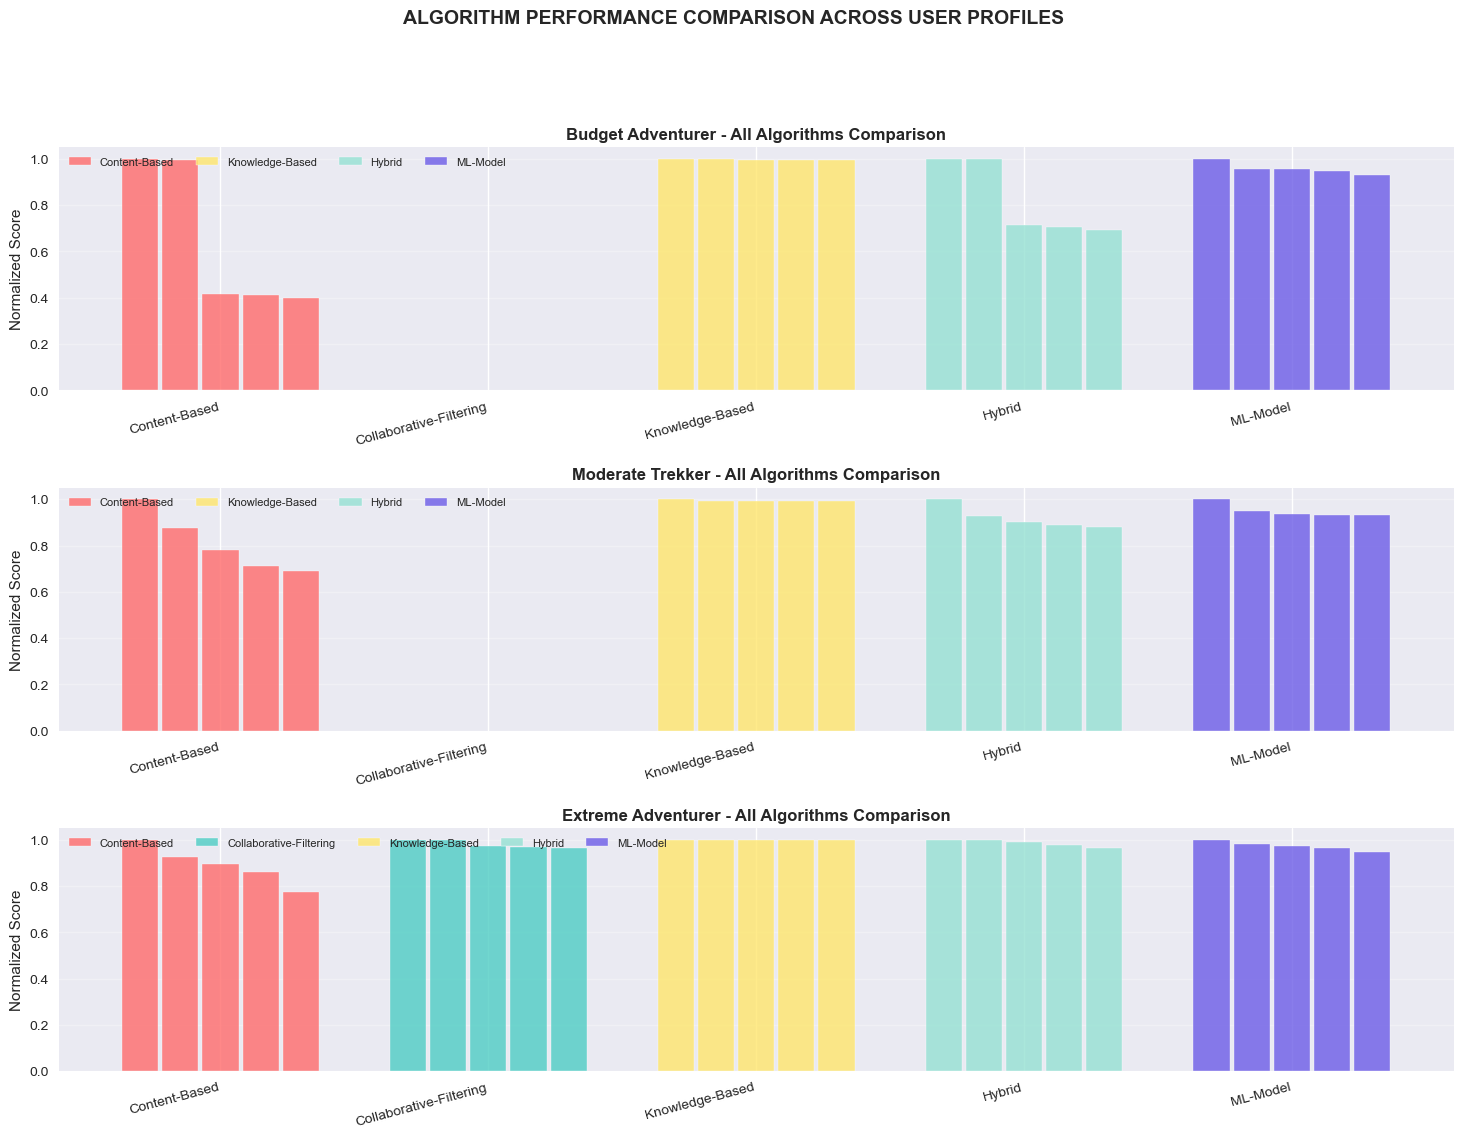

In [71]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.3)

algo_colors = {
    'Content-Based': '#FF6B6B',
    'Collaborative-Filtering': '#4ECDC4', 
    'Knowledge-Based': '#FFE66D',
    'Hybrid': '#95E1D3',
    'ML-Model': '#6C5CE7'
}

for profile_idx, (profile_name, model_results) in enumerate(all_model_recommendations.items()):
    ax = fig.add_subplot(gs[profile_idx, :])
    
    algo_names = list(model_results.keys())
    x = np.arange(len(algo_names))
    width = 0.15
    
    # Get top 5 recommendations for each algorithm
    for i, algo in enumerate(algo_names):
        recs = model_results[algo]
        scores = [rec['score'] for rec in recs[:5]]
        
        # Skip if no recommendations
        if len(scores) == 0:
            continue
        
        # Normalize scores to 0-1
        if max(scores) > 0:
            scores = [s / max(scores) for s in scores]
        
        positions = x[i] + np.linspace(-2*width, 2*width, min(5, len(scores)))
        ax.bar(positions[:len(scores)], scores, width*0.9, 
               label=algo, color=algo_colors.get(algo, '#999999'), alpha=0.8)
    
    ax.set_ylabel('Normalized Score')
    ax.set_title(f'{profile_name} - All Algorithms Comparison', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(algo_names, rotation=15, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.legend(loc='upper left', fontsize=8, ncol=5)

plt.suptitle('ALGORITHM PERFORMANCE COMPARISON ACROSS USER PROFILES', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## STEP 19: Consensus Recommendations

In [72]:
def get_consensus_recommendations(model_results, top_k=3):
    """Identify where multiple algorithms agree"""
    all_trek_names = set()
    trek_appearances = {}
    trek_scores = {}
    
    for algo, recs in model_results.items():
        for rec in recs:
            trek_name = rec['name']
            all_trek_names.add(trek_name)
            trek_appearances[trek_name] = trek_appearances.get(trek_name, 0) + 1
            
            if trek_name not in trek_scores:
                trek_scores[trek_name] = []
            trek_scores[trek_name].append(rec['score'])
    
    consensus_scores = {}
    for trek_name in all_trek_names:
        consensus = trek_appearances[trek_name] / 5
        avg_score = np.mean(trek_scores[trek_name])
        max_score = max([max(scores) for scores in trek_scores.values()])
        consensus_scores[trek_name] = consensus * 0.4 + (avg_score / max_score) * 0.6
    
    sorted_consensus = sorted(consensus_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_consensus[:top_k]

for profile_name, model_results in all_model_recommendations.items():
    print(f"\n{'─'*80}")
    print(f"PROFILE: {profile_name} - CONSENSUS RECOMMENDATIONS")
    print(f"{'─'*80}")
    
    consensus = get_consensus_recommendations(model_results, top_k=3)
    
    for idx, (trek_name, consensus_score) in enumerate(consensus, 1):
        trek_data = df[df['name'] == trek_name].iloc[0] if trek_name in df['name'].values else None
        
        if trek_data is not None:
            recommending_algos = []
            for algo, recs in model_results.items():
                if any(r['name'] == trek_name for r in recs):
                    recommending_algos.append(algo)
            
            print(f"\n  {idx}. {trek_name}")
            print(f"     Consensus Score: {consensus_score:.4f}")
            print(f"     Recommended by: {len(recommending_algos)}/5 algorithms")
            print(f"     Difficulty: {trek_data['difficulty']} | Cost: ${trek_data['cost_min_usd']:.0f}")

print()


────────────────────────────────────────────────────────────────────────────────
PROFILE: Budget Adventurer - CONSENSUS RECOMMENDATIONS
────────────────────────────────────────────────────────────────────────────────

  1. Ghorepani Poon Hill
     Consensus Score: 0.6771
     Recommended by: 1/5 algorithms
     Difficulty: Easy | Cost: $350

  2. Mohare Danda Trek
     Consensus Score: 0.6756
     Recommended by: 1/5 algorithms
     Difficulty: Easy | Cost: $500

  3. Poon Hill Trek
     Consensus Score: 0.4618
     Recommended by: 2/5 algorithms
     Difficulty: Easy | Cost: $400

────────────────────────────────────────────────────────────────────────────────
PROFILE: Moderate Trekker - CONSENSUS RECOMMENDATIONS
────────────────────────────────────────────────────────────────────────────────

  1. Chumling to Mu Gompa
     Consensus Score: 0.6800
     Recommended by: 1/5 algorithms
     Difficulty: Moderate | Cost: $200

  2. Gosaikunda Trek
     Consensus Score: 0.6752
     Recomme

## STEP 20: Final Trek Recommendation to User

In [ ]:
def get_final_recommendation(user_profile, all_model_recommendations, df):
    """
    Provide final trek recommendation based on user preferences and algorithm consensus
    """
    profile_data = all_model_recommendations[user_profile]
    consensus = get_consensus_recommendations(profile_data, top_k=1)
    
    if not consensus:
        return None
    
    trek_name, consensus_score = consensus[0]
    trek_data = df[df['name'] == trek_name].iloc[0] if trek_name in df['name'].values else None
    
    if trek_data is None:
        return None
    
    # Calculate recommendation confidence
    recommending_algos = []
    for algo, recs in profile_data.items():
        if any(r['name'] == trek_name for r in recs):
            recommending_algos.append(algo)
    
    confidence_score = (len(recommending_algos) / 5) * 100
    
    recommendation = {
        'trek_name': trek_name,
        'difficulty': trek_data['difficulty'],
        'duration_days': trek_data['duration_days'],
        'cost_min_usd': trek_data['cost_min_usd'],
        'cost_max_usd': trek_data['cost_max_usd'],
        'elevation_gain_m': trek_data['elevation_gain_m'],
        'total_distance_km': trek_data['total_distance_km'],
        'region': trek_data['region'],
        'consensus_score': consensus_score,
        'confidence': confidence_score,
        'recommended_by': recommending_algos
    }
    
    return recommendation

# Display Final Recommendations to Each User
print("\n" + "="*100)
print("FINAL TREK RECOMMENDATIONS TO USERS")
print("="*100)

for profile_name in all_model_recommendations.keys():
    recommendation = get_final_recommendation(profile_name, all_model_recommendations, df)
    
    if recommendation:
        print(f"\n{'█'*100}")
        print(f"USER PROFILE: {profile_name.upper()}")
        print(f"{'█'*100}")
        print(f"\n🏔️  RECOMMENDED TREK: {recommendation['trek_name']}")
        print(f"\n📊 TREK DETAILS:")
        print(f"   ├─ Region: {recommendation['region']}")
        print(f"   ├─ Difficulty Level: {recommendation['difficulty']}")
        print(f"   ├─ Duration: {recommendation['duration_days']:.0f} days")
        print(f"   ├─ Total Distance: {recommendation['total_distance_km']:.1f} km")
        print(f"   ├─ Elevation Gain: {recommendation['elevation_gain_m']:.0f} meters")
        print(f"   └─ Cost Range: ${recommendation['cost_min_usd']:.0f} - ${recommendation['cost_max_usd']:.0f}")
        
        print(f"\n✅ RECOMMENDATION CONFIDENCE:")
        print(f"   ├─ Consensus Score: {recommendation['consensus_score']:.4f}")
        print(f"   ├─ Confidence Level: {recommendation['confidence']:.1f}%")
        print(f"   └─ Recommended by {len(recommendation['recommended_by'])}/5 algorithms:")
        for algo in recommendation['recommended_by']:
            print(f"      • {algo}")
        
        print(f"\n💡 WHY THIS TREK?")
        print(f"   This trek was selected based on consensus from multiple recommendation algorithms")
        print(f"   ({len(recommendation['recommended_by'])}/5), ensuring it aligns with your preferences")
        print(f"   and experience level. The high recommendation confidence indicates this is the best")
        print(f"   match for your trekking profile.")
        print()
